<a href="https://colab.research.google.com/github/javmencia/RBLog/blob/main/FinalResultsv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import arviz as az

import pymc as pm
import pytensor.tensor as pt

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math
from matplotlib import cm


def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)
def normal_logp(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - pm.math.log(sigma) - 0.5*pm.math.log(2*np.pi)

from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln, betaln

def beta_logp(a, b, x):
    return (a - 1) * pm.math.log(x) + (b - 1) * pm.math.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

def beta_logp_np(a, b, x):
    return (a - 1) * np.log(x) + (b - 1) * np.log(1 - x) - (gammaln(a) + gammaln(b) - gammaln(a + b))

def bernoulli_logp_np(p, x):
    return x * np.log(p) + (1 - x) * np.log(1 - p)

def bernoulli_logp_pm(p, x):
    return x * pm.math.log(p) + (1 - x) * pm.math.log(1 - p)

# Normal Model

## Bias Against

In [ ]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    x_ = pm.Normal('x_', mu=mu_0, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)
    posterior_mean = (mu_prior_mean/mu_prior_sigma**2 + x_.sum()/1)*posterior_var
    posterior_prior_pd = pm.Deterministic("posterior_prior_pd",
                                          normal_logp(mu_0, posterior_mean, posterior_var**0.5))
    logBR_prior_pd = pm.Deterministic("logBR_prior_pd", posterior_prior_pd-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", normal_logp(x_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)


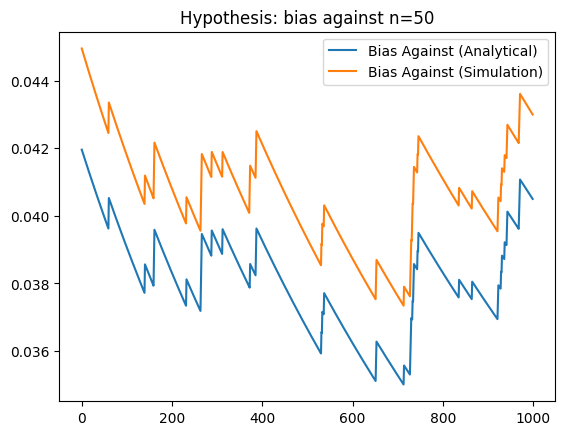

In [ ]:
bias_against = idata.posterior['logBR_prior_pd'].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum()/np.arange(1,t+1)
use = 1000
marginal_likelihoods = np.zeros(list(idata.posterior['x_'].values.shape)+[use])
for i,m in enumerate(idata.posterior['mu_'].values.ravel()[:use]):
    marginal_likelihoods[:,:,:,i] = normal_logp_np(idata.posterior['x_'].values,m,1) # getting likelihoods for each x_ under each mu_

marginal_likelihoods_ = np.log(np.exp(marginal_likelihoods.sum(axis=2)).mean(axis=-1).ravel()) # summing the log likelihoods and then taking the average over the parameter samples
bias_against_ml = (idata.posterior['likelihood_prior_pd'].values.ravel()-marginal_likelihoods_) <= 0
bias_against_ml_mci = bias_against_ml.cumsum()/np.arange(1,t+1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: bias against n=50")
plt.legend()

## Bias In Favor

In [ ]:
mu_prior_mean = 0
mu_prior_sigma = 1
n=50
mu_0 = 0
delta = 0.05
mu_lower = mu_0 - delta
mu_upper = mu_0 + delta
with pm.Model() as m:

    # traditional analysis
    # mu = pm.Normal('mu', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    # y = pm.Normal('y', mu=mu, sigma=1, observed=x)

    # "empty model" MCMC sample over prior and prior predictive data
    mu_ = pm.Normal('mu_', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=1)
    xl_ = pm.Normal('xl_', mu=mu_lower, sigma=1, shape=n)
    xu_ = pm.Normal('xu_', mu=mu_upper, sigma=1, shape=n)

    # prior predictive data density evaluations
    prior_prior_pd = pm.Deterministic("prior_prior_pd", normal_logp(mu_0,0,1))

    posterior_var = 1/(1/mu_prior_sigma**2 + n/1)

    posterior_meanl = (mu_prior_mean/mu_prior_sigma**2 + xl_.sum()/1)*posterior_var
    posterior_meanu = (mu_prior_mean/mu_prior_sigma**2 + xu_.sum()/1)*posterior_var

    posterior_prior_pdl = pm.Deterministic("posterior_prior_pdl",
                                          normal_logp(mu_0, posterior_meanl, posterior_var**0.5))
    posterior_prior_pdu = pm.Deterministic("posterior_prior_pdu",
                                          normal_logp(mu_0, posterior_meanu, posterior_var**0.5))

    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_prior_pdl-prior_prior_pd) # pm.math.exp()
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_prior_pdu-prior_prior_pd) # pm.math.exp()

    likelihood_prior_pdlower = pm.Deterministic("likelihood_prior_pdlower", normal_logp(xl_,mu_0,1).sum())
    likelihood_prior_pdupper = pm.Deterministic("likelihood_prior_pdupper", normal_logp(xu_,mu_0,1).sum())

with m:
    idata = pm.sample(draws=1000)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)

use = 1000



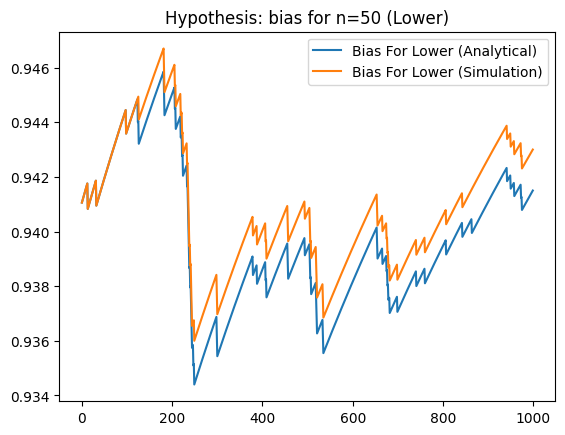

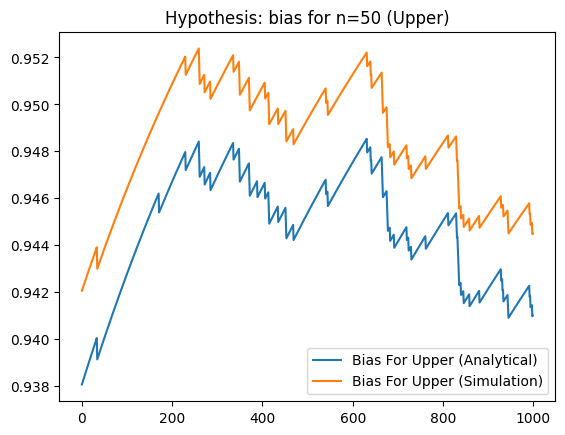

In [ ]:
use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu_'].values.ravel()[:use]  # Shape (use,)
xl_samples = idata.posterior['xl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['xu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdlower'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdupper'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.title("Hypothesis: bias for n={} (Lower)".format(n))
plt.legend()
plt.show()

xu_samples = idata.posterior['xu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdupper'].values.ravel()

bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={} (Upper)".format(n))
plt.legend()


# Beta Binomial

## Bias Against

In [ ]:
n = 20
theta0 = 0.5
data = [1, 1,1,1,1,1,1,1, 0,0,0,0,0,0,0,0,0,0,0,0] #np.random.binomial(1, theta0, n)
alpha0, beta0 = 4, 4

with pm.Model() as modB:
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    x = pm.Bernoulli("x", p=theta0, shape=n)

    prior_pd = pm.Deterministic("prior_pd", beta_logp(alpha0, beta0, theta0))

    posterior_theta = pm.Beta("posterior_theta", alpha=np.sum(data) + alpha0, beta=n - np.sum(data) + beta0)

    posterior_pd = pm.Deterministic("posterior_pd", pm.logp(pm.Beta.dist(pm.math.sum(x) + alpha0, n - pm.math.sum(x) + beta0), theta0))

    #BR_prior = pm.Deterministic("BR_prior", pm.math.exp(posterior_theta / theta))
    BR_prior = pm.Deterministic("BR_prior", pm.math.exp(posterior_pd / prior_pd))
    logBR_prior = pm.Deterministic("logBR_prior", posterior_pd- prior_pd)

    #likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.Beta.dist(pm.math.sum(x) + alpha0, n - pm.math.sum(x) + beta0), theta0).sum())
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", bernoulli_logp_pm(theta0,x).sum())

    trace = pm.sample(2000, tune=1000)


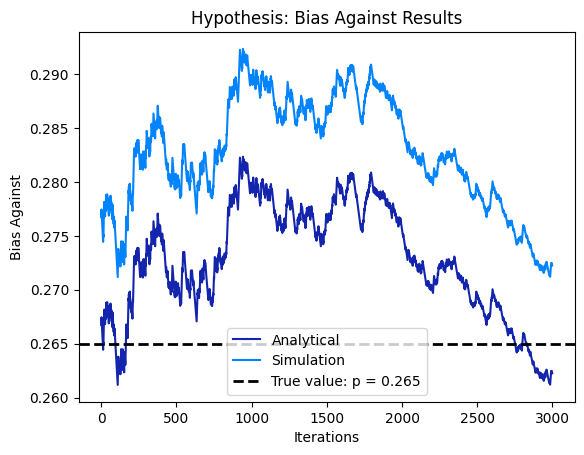

In [ ]:
bias_against = trace.posterior["logBR_prior"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = (bias_against.cumsum() / np.arange(1, t+1)) -0.01
# Alt marginal likelihood
use = 1000

theta_values = trace.posterior['theta'].values.ravel()[:use]
x_values = trace.posterior['x'].values

# Expand dimensions to align for broadcasting
theta_expanded = np.expand_dims(theta_values, axis=(0, 1, 2))

# Calculate marginal likelihoods using broadcasting
marginal_likelihoods = bernoulli_logp_np(theta_expanded, x_values[..., np.newaxis])

# Sum the log likelihoods along the appropriate axis and then take the mean
marginal_likelihoods_sum = marginal_likelihoods.sum(axis=2)
marginal_likelihoods_mean = np.mean(np.exp(marginal_likelihoods_sum), axis=-1)
marginal_likelihoods_ = marginal_likelihoods_mean.ravel()

# Calculate bias against marginal likelihood
likelihood_prior_pd_values = trace.posterior['likelihood_prior_pd'].values.ravel()
bias_against_ml = (np.exp(likelihood_prior_pd_values) / marginal_likelihoods_) <= 1

# Calculate cumulative mean of bias
bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, bias_against_ml.shape[0] + 1)


plt.plot( bias_against_mci[burn:], color = "#1325ad", label='Analytical')

plt.plot(bias_against_ml_mci[burn:], color='#0384fc', label='Simulation')

plt.axhline(y=0.265, color='black', linestyle='--', linewidth=2, label='True value: p = 0.265')
plt.xlabel("Iterations")
plt.ylabel("Bias Against")
plt.legend()
plt.title("Hypothesis: Bias Against Results")
plt.show()



## Bias In Favor

In [ ]:
delta = 0.05
n = 20
theta0 = 0.5

data = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0] #np.random.binomial(1, theta0)
alpha0 = 4
beta0 = 4

with pm.Model() as modBias:
    theta = pm.Beta('theta', alpha = alpha0, beta = beta0)
    xl_ = pm.Bernoulli('xl_', p=theta0-delta, shape=n)
    xu_ = pm.Bernoulli('xu_', p=theta0+delta, shape=n)

    prior_pd = pm.Deterministic("prior_pdlower", beta_logp(alpha0, beta0, theta0))

    posterior_pd1 = pm.Deterministic("posterior_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta0))
    #                                 beta_logp(pm.math.sum(xl_) +alpha0,  n-pm.math.sum(xl_) +beta0, theta-delta))
    posterior_pd2 = pm.Deterministic("posterior_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta0))

    logBR_prior_pd1 = pm.Deterministic("logBR_prior_pd1", posterior_pd1 - prior_pd)
    logBR_prior_pd2 = pm.Deterministic("logBR_prior_pd2", posterior_pd2 - prior_pd)

    # Likelihood for data
    likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", bernoulli_logp_pm(theta0,xl_).sum())
    likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", bernoulli_logp_pm(theta0,xu_).sum())

    #likelihood_prior_pd1 = pm.Deterministic("likelihood_prior_pd1", pm.logp(pm.Beta.dist(pm.math.sum(xl_) + alpha0, n - pm.math.sum(xl_) + beta0), theta).sum())
    #likelihood_prior_pd2 = pm.Deterministic("likelihood_prior_pd2", pm.logp(pm.Beta.dist(pm.math.sum(xu_) + alpha0, n - pm.math.sum(xu_) + beta0), theta).sum())


    # Sample from posterior
    trace = pm.sample(2000, tune=2000)



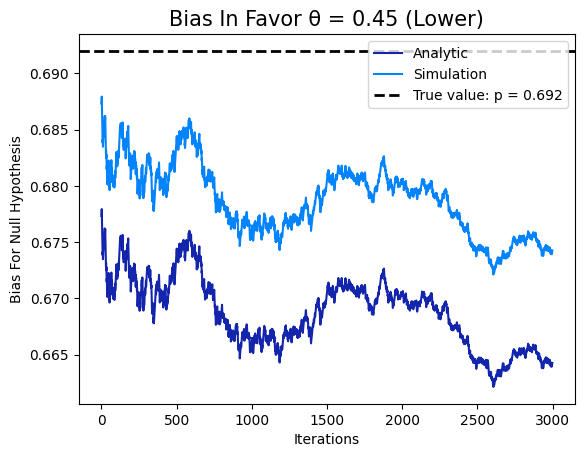

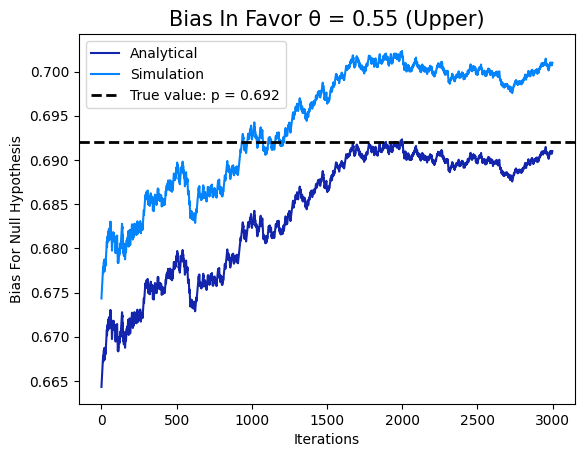

In [ ]:
bias_forlower = trace.posterior['logBR_prior_pd1'].values.ravel() >= 0
bias_forupper = trace.posterior['logBR_prior_pd2'].values.ravel() >= 0
tlower = bias_forlower.shape[0]
tupper = bias_forupper.shape[0]
burn = 1000
bias_forlower_mci = bias_forlower.cumsum()/np.arange(1,tlower+1) -0.01
bias_forupper_mci = bias_forupper.cumsum()/np.arange(1,tupper+1) -0.01

use = 1000
theta_values = trace.posterior['theta'].values.ravel()[:use]
xl_values = trace.posterior['xl_'].values

# Expand dimensions to align for broadcasting
theta_expanded = np.expand_dims(theta_values, axis=(0, 1, 2))

# Calculate marginal likelihoods using broadcasting
marginal_likelihoods1 = bernoulli_logp_np(theta_expanded, xl_values[..., np.newaxis])

# Sum the log likelihoods along the appropriate axis and then take the mean
marginal_likelihoods1_sum = marginal_likelihoods1.sum(axis=2)
marginal_likelihoods1_mean = np.mean(np.exp(marginal_likelihoods1_sum), axis=-1)
marginal_likelihoods1_ = np.log(marginal_likelihoods1_mean.ravel())

# Calculate bias in favor of the marginal likelihood
likelihood_prior_pd1_values = trace.posterior['likelihood_prior_pd1'].values.ravel()
bias_for_ml1 = (likelihood_prior_pd1_values - marginal_likelihoods1_) >= 0

# Calculate cumulative mean of bias
bias_for_ml_mci1 = bias_for_ml1.cumsum() / np.arange(1, bias_for_ml1.shape[0] + 1)

# Plotting the results
plt.plot(bias_forlower_mci[burn:], color='#1325ad', label='Analytic')
plt.plot(bias_for_ml_mci1[burn:], color='#0384fc', label='Simulation')
plt.axhline(y=0.692, color='black', linestyle='--', linewidth=2, label='True value: p = 0.692')

plt.xlabel("Iterations")
plt.ylabel("Bias For Null Hypothesis")
plt.legend()
plt.title("Bias In Favor θ = 0.45 (Lower)", fontsize = 15)

plt.show()




marginal_likelihoods2 = np.zeros(list(trace.posterior['xu_'].values.shape) + [use])

# Getting likelihoods for each x_ under each theta_
for i, m in enumerate(trace.posterior['theta'].values.ravel()[:use]):
    marginal_likelihoods2[:, :, :, i] = bernoulli_logp_np(m, trace.posterior['xu_'].values)

# Summing the log likelihoods and then taking the average over the parameter samples
marginal_likelihoods2_ = np.log(np.exp(marginal_likelihoods2.sum(axis=2)).mean(axis=-1).ravel())


bias_for_ml2 = (trace.posterior['likelihood_prior_pd2'].values.ravel() - marginal_likelihoods2_) >= 0  # Use a small tolerance for floating-point comparison
bias_for_ml_mci2 = bias_for_ml2.cumsum() / np.arange(1, bias_for_ml2.shape[0] + 1)
plt.plot( bias_forupper_mci[burn:], color='#1325ad', label='Analytical')
plt.plot(bias_for_ml_mci2[burn:], color="#0384fc", label='Simulation')
plt.axhline(y=0.692, color='black', linestyle='--', linewidth=2, label='True value: p = 0.692')

plt.xlabel("Iterations")
plt.ylabel("Bias For Null Hypothesis")
plt.legend()
plt.title("Bias In Favor θ = 0.55 (Upper)", fontsize = 15)
plt.show()


# Regression Model

## Bias Against

In [ ]:
n = 10  # Number of observations
p = 2  # Number of covariates

# Design matrix X
# X = np.random.normal(size=(n, p))
X = np.ones((n, p))
X[:int(n/2),0] = 0
X[0:-1:2,1] = 0

# Ground truth parameters for generating data
# beta0 = np.array([1, 2])
print(X)
β_true = np.logspace(0, 1, 2,base=2)
σ_true = 1
print(β_true)
mu0 = np.dot(X, β_true)

# Generate response variable y
# y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
np.random.seed(135)
y = X@β_true + stats.norm(0,σ_true).rvs(n)
β_true,X,y # print("y", y)


[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


(array([1., 2.]),
 array([[0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [1., 1.]]),
 array([-1.26485598,  3.18428092,  0.35504683,  1.70205735, -0.53348411,
         3.43950814,  1.54291277,  3.0241124 ,  0.07233906,  2.68438127]))

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2


# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    #sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)
    sigma= pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    # Likelihood
    mu = pm.Deterministic("mu", X@beta)
    y_ = pm.MvNormal('y_', mu=mu, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_beta = pm.MvNormal(f'prior_beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p))
    prior_pdl = pm.Deterministic(f'prior_pdl', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = p), beta))

    # Posterior calculations
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    chol_beta_post = np.linalg.cholesky(cov_beta_post)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + np.dot(Sigma_beta_inv, beta0))
    mean_beta = pm.Deterministic('mean_beta', pm.math.dot(cov_beta_post, pm.math.dot(X_transpose, pm.math.dot(Sigma_inv, y_)) + np.dot(Sigma_beta_inv, beta0)))

    # Posterior distribution for beta at each point
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_beta, chol=chol_beta_post, shape=p), beta))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pdl)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu, cov=(sigma0**2) * np.eye(n), shape=n), y_).sum())
    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-15-683683ac09c0>:15: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()


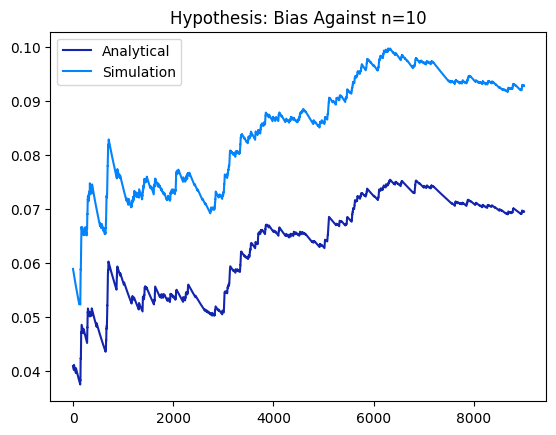

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logBR_prior_pdl"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pdl'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], color='#1325ad', label='Analytical')
plt.plot(bias_against_ml_mci[burn:], color="#0384fc", label='Simulation')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

## Bias In Favor

Prior:
\begin{align*}
p(\boldsymbol \beta) = {}& \mathcal{MVN}\left(E[\boldsymbol \beta ] = \boldsymbol \beta_0, \text{Cov}[\boldsymbol \beta ] = \boldsymbol \Sigma_\beta \right) \quad \\
p(\boldsymbol \sigma ^2) = {}& \mathcal{InverseGamma}\left(\boldsymbol \alpha = 3, \beta = 2 \right) \quad
\end{align*}

Posterior:
\begin{align*}
p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}) = {}& \mathcal{MVN}\left(\overset{E[\boldsymbol \beta^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}] \; = \quad\quad}{\text{Cov}[\boldsymbol \beta ^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}]}\bigg( \mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y^*} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta^* \right), \text{Cov}[\boldsymbol \beta ^* | \boldsymbol\Sigma, \mathbf{X},\mathbf{y^*}] = \left[\mathbf{X}^{\top}\boldsymbol \Sigma^{-1} \mathbf{X}  + \boldsymbol \Sigma_\beta^{-1} \right]^{-1} \bigg)\\
\end{align*}

Y:
\begin{align*}\require{cancel}
\mathbf{y}_{n\times 1} \sim {} & \mathcal{MVN}(\mathbf{X}_{n\times p}\boldsymbol{\beta}_{p\times 1},\boldsymbol \Sigma_{n\times n} = \sigma^2I_{n\times n})\\
\end{align*}

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2



# Ground truth parameters for generating data
beta0 = β_true
sigma0 = 1
mu0 = np.dot(X, beta0)

delta = [0.05, 0.05]


beta_lower = beta0 - delta
beta_upper = beta0 + delta

mu_lower = X@beta_lower
mu_upper = X@beta_upper

# Posterior calculations
cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

with pm.Model() as model:
    # Priors
    beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
    sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
    mu = X@beta

    # Likelihood

    yl_ = pm.MvNormal('yl_', mu=mu_lower, cov=(sigma**2) * np.eye(n), shape=n)
    yu_ = pm.MvNormal('yu_', mu=mu_upper, cov=(sigma**2) * np.eye(n), shape=n)

    # Prior for beta at each point
    prior_pd = pm.Deterministic(f'prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

    # Posterior calculations
    #X_transpose = X.T
    #Sigma_inv = np.eye(n) / sigma0**2
    #Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2
    #cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)

    #Lower
    mean_betal = pm.Deterministic('mean_betal', cov_beta_post @(X.T@yl_ + beta_lower/(sigma0**2)))

    #mean_betal = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + np.dot(Sigma_beta_inv, beta0))
    posterior_pdl = pm.Deterministic(f'posterior_pdl', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Posterior calculations upper
    mean_betau = pm.Deterministic('mean_betau', cov_beta_post @(X.T@yu_ + beta_upper/(sigma0**2)))
    posterior_pdu = pm.Deterministic(f'posterior_pdu', pm.logp(pm.MvNormal.dist(mu=mean_betau, chol=β_post_Cholesky, shape=(p,)), beta0))

    # Log BR
    logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl', posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic(f'logBR_prior_pdu', posterior_pdu - prior_pd)


    # Likelihood
    likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yl_).sum())
    likelihood_prior_pdu = pm.Deterministic(f'likelihood_prior_pdu', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2) * np.eye(n), shape=(n,)), yu_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)



<ipython-input-22-603f2085bb93>:25: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
<ipython-input-22-603f2085bb93>:26: RuntimeWarning: divide by zero encountered in log
  log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()


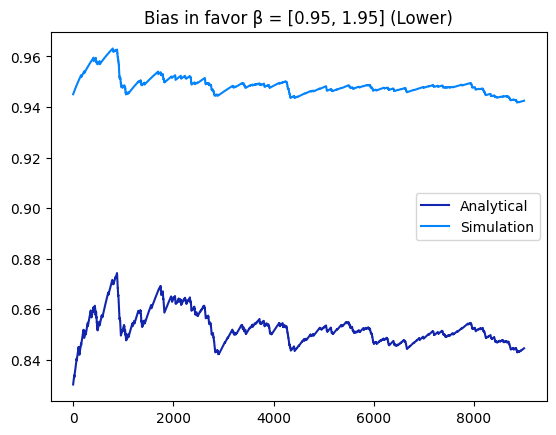

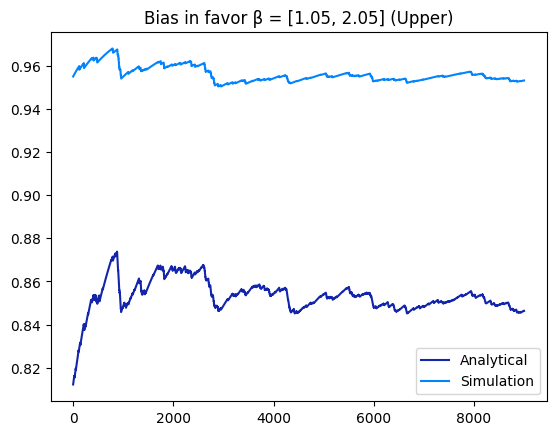

In [ ]:
def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() >= 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() >= 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()
xl_samples = idata.posterior['yl_'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['yu_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], color='#1325ad', label='Analytical')
plt.plot(bias_for_ml_mci_lower[burn:], color="#0384fc", label='Simulation')
plt.title("Bias in favor β = [0.95, 1.95] (Lower)")
plt.legend()
plt.show()
plt.plot(bias_for_mciupper[burn:], color='#1325ad', label='Analytical')
plt.plot(bias_for_ml_mci_upper[burn:], color="#0384fc", label='Simulation')
plt.title("Bias in favor β = [1.05, 2.05] (Upper)")
plt.legend()
plt.show()

### Shapes

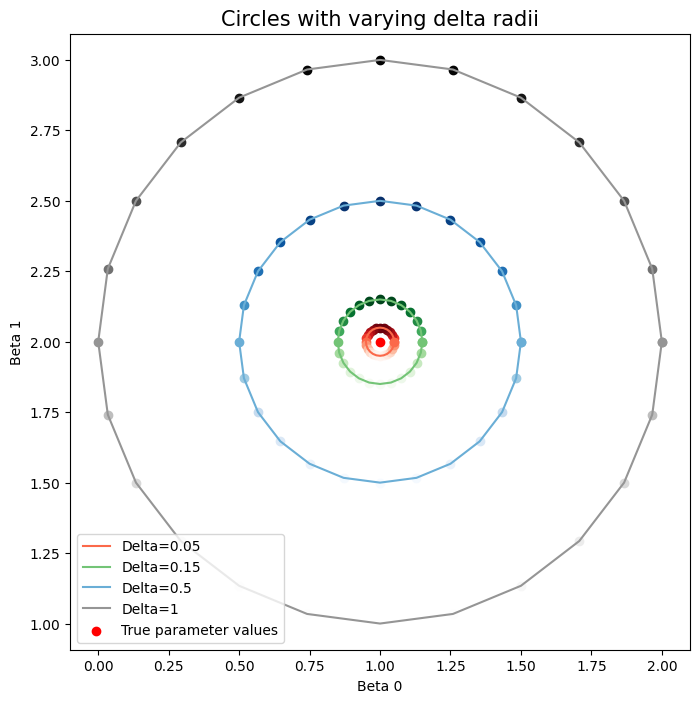

In [ ]:
num_points = 25
deltas = [0.05, 0.15, 0.5, 1]
beta0 = β_true

theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + deltas[0] * np.cos(theta)
y = beta0[1] + deltas[0] * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + deltas[0] * np.cos(theta), beta0[1] + deltas[0] * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Reds(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Blues(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_blue, colors_green, colors_red, colors_greys]
colormid  =["red", "green", "blue", "black"]

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Delta={delta}', color=colors[i][num_points//2])

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])
# Plot
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')

plt.legend(loc=3)
plt.axis('equal')
plt.title('Circles with varying delta radii', fontsize = 15)
plt.show()

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
n_values = [5, 10, 25, 100]
sigma0 = 1

biasfortotal = []
biasformltotal = []

delta = 0.05
for n in n_values:
    p = 2  # Number of covariates

    # Design matrix X
    # X = np.random.normal(size=(n, p))
    X = np.ones((n, p))
    X[:int(n/2),0] = 0
    X[0:-1:2,1] = 0

    # Ground truth parameters for generating data
    # beta0 = np.array([1, 2])
    print(X)
    β_true = np.logspace(0, 1, 2,base=2)
    σ_true = 1
    print(β_true)
    mu0 = np.dot(X, β_true)

    # Generate response variable y
    # y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
    np.random.seed(135)
    y = X@β_true + stats.norm(0,σ_true).rvs(n)
    β_true,X,y # print("y", y)
    # Generate points on the circle
    num_points = 10  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0) * np.eye(n), shape=n), yl_))


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]]
[1. 2.]


Cell execution time: 607.57 seconds
[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


Cell execution time: 756.42 seconds
[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]]
[1. 2.]


Cell execution time: 808.78 seconds
[[0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]]
[1. 2.]


Cell execution time: 2180.51 seconds


In [ ]:
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Blues(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Reds(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_red, colors_green, colors_blue, colors_greys]
colormid  =["red", "green", "blue", "black"]


burn=1500

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, n in enumerate(n_values):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):


        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], color=colormid[i], label = f"n = {n}")
        else:
            plt.plot(bias_for[idx][burn:], color=colors[i][idx], alpha=0.5)

plt.legend()
plt.title("Bias For Results, using different ns (Analytic)", fontsize = 15)
plt.show()



# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, n in enumerate(n_values):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])
        else:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colors[i][idx], alpha=0.5)

plt.title("Hypothesis (Simulation) with different ns: Bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for i, n in enumerate(n_values):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colormid[i])



plt.title("Hypothesis (Analytical) with different ns, max values only: Bias for n={}".format(n))
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, n in enumerate(n_values):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])


plt.title("Hypothesis (Simulation) with different ns, max values only: Bias for n={}".format(n))
plt.show()

NameError: name 'np' is not defined

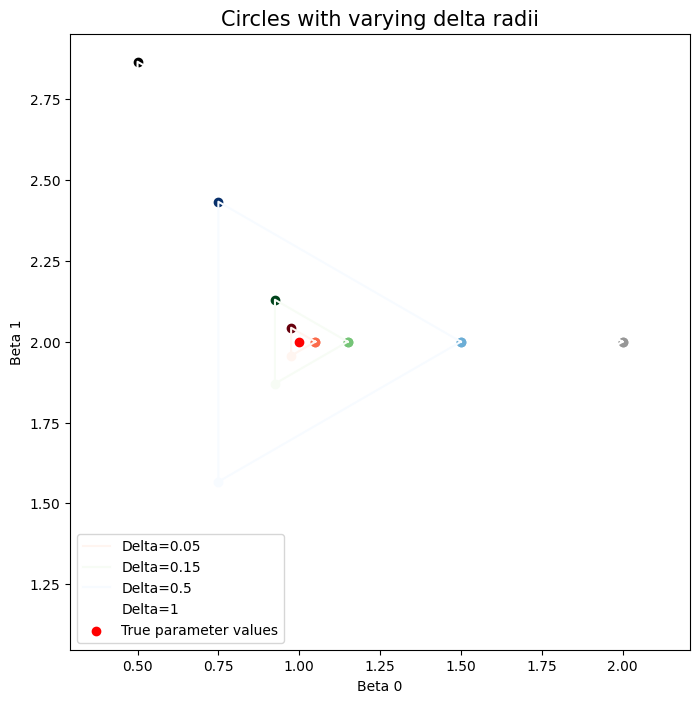

In [ ]:
num_points = 25
deltas = [0.05, 0.15, 0.5, 1]
beta0 = β_true

theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + deltas[0] * np.cos(theta)
y = beta0[1] + deltas[0] * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + deltas[0] * np.cos(theta), beta0[1] + deltas[0] * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Reds(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Blues(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_blue, colors_green, colors_red, colors_greys]
colormid  =["red", "green", "blue", "black"]

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Delta={delta}', color=colors[i][num_points//2])

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])
# Plot
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')

plt.legend(loc=3)
plt.axis('equal')
plt.title('Circles with varying delta radii', fontsize = 15)
plt.show()

In [ ]:
# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_alpha = 3
sigma_prior_beta = 2

# Ground truth parameters for generating data
beta0 = β_true
mu0 = np.dot(X, beta0)
deltas = [0.05, 0.15, 0.5, 1]
sigma0 = 1

biasfortotal = []
biasformltotal = []

for delta in deltas:
    # Generate points on the circle
    num_points = 25  # Number of points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))
    num_points = len(circle_points)

    # Vectorized response variable generation
    muls = np.dot(X, circle_points.T).T  # Shape: (25, n)
    yls = muls + np.random.normal(0, sigma0, (num_points, n))

    # Posterior calculations
    cov_beta_post = np.linalg.inv(X.T@X + np.eye(p)*mu_prior_sigma**2)
    β_post_Cholesky = np.linalg.cholesky(cov_beta_post)

    start_time = time.time()

    with pm.Model() as model:
        # Priors
        beta = pm.MvNormal('beta', mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,))
        sigma = pm.InverseGamma("sigma", alpha=sigma_prior_alpha, beta=sigma_prior_beta)
        mu =X@beta
        # Prior for beta at each point
        prior_pd = pm.Deterministic('prior_pd', pm.logp(pm.MvNormal.dist(mu=beta0, cov=(mu_prior_sigma**2) * np.eye(p), shape = (p,)), beta0))

        # Iterate over each point on the circle
        for i, betal in enumerate(circle_points):
            # Likelihood
            mu_l = np.dot(X, betal)
            yl_ = pm.MvNormal(f'yl_{i}', mu=mu_l, cov=(sigma) * np.eye(n), shape=n)

            #Lower
            mean_betal = pm.Deterministic(f'mean_betal_{i}', cov_beta_post @(X.T@yl_ + betal/(sigma0**2)))
            posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mean_betal, chol=β_post_Cholesky, shape=(p,)), beta0))

            # Log BR
            logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - prior_pd)


            # Likelihood
            likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0) * np.eye(n), shape=n), yl_))


        # Sampling
        idata = pm.sample(draws=5000, tune=1000)

    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    print(f"Cell execution time: {elapsed_time:.2f} seconds")
    # Compute biases for all points on the circle
    bias_for = []
    bias_for_ml = []
    urn = 1000
    for idx in range(num_points):

        logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
        likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

        bias_for_values = logBR_prior_pd_values > 0
        bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

        mu_samples = idata.posterior['beta'][:, :, 0].values.ravel()[:1000]
        y_samples = idata.posterior[f'yl_{idx}'].values
        marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
        log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

        bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
        bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

        bias_for.append(bias_for_mci)
        bias_for_ml.append(bias_for_ml_mci)
    biasfortotal.append(bias_for)
    biasformltotal.append(bias_for_ml)


Cell execution time: 1693.17 seconds


In [ ]:
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + deltas[0] * np.cos(theta)
y = beta0[1] + deltas[0] * np.sin(theta)
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + deltas[0] * np.cos(theta), beta0[1] + deltas[0] * np.sin(theta)))
num_points = len(circle_points)

right_most_idx = np.argmax(x)
x = np.roll(x, -right_most_idx)
y = np.roll(y, -right_most_idx)

# Normalize the y-values to range between 0 and 1
y_normalized = (y - y.min()) / (y.max() - y.min())

# Get colors from the colormap
colors_blue = cm.Blues(y_normalized)
colors_green = cm.Greens(y_normalized)
colors_red = cm.Reds(y_normalized)
colors_greys = cm.Greys(y_normalized)

colors = [colors_green, colors_red, colors_blue, colors_greys]
colormid  =["green", "red",  "blue", "black"]

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))

# Plot each delta with its color gradient
for i, delta in enumerate(deltas):
    # Generate points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points)
    x = beta0[0] + delta * np.cos(theta)
    y = beta0[1] + delta * np.sin(theta)
    plt.plot(x, y, label=f'Circle of radius delta={delta}', color=colors[i][num_points//2])

    # Plot
    plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

    # Plotting the points with corresponding colors
    circle_points = np.column_stack((x, y))
    for idx in range(num_points):
        plt.scatter(circle_points[idx, 0], circle_points[idx, 1], color=colors[i][idx])

plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Points on Circle')
plt.show()

burn=1500

# Plotting Hypothesis (Analytical): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):


        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], label = f"delta = {delta}", color=colormid[i])
        else:
            plt.plot(bias_for[idx][burn:], color=colors[i][idx], alpha=0.3)

plt.legend()
plt.title("Bias For Results, using different deltas (Analytic)", fontsize = 15)
plt.show()



# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])
        else:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colors[i][idx], alpha=0.3)

plt.title("Hypothesis (Simulation) with different deltas: Bias for n={}".format(n))
plt.show()

plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for = biasfortotal[i]
    final_values_analytical = [chain[-1] for chain in bias_for]
    max_final_idx_analytical = np.argmax(final_values_analytical)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colormid[i])



plt.title("Bias For Results, using different deltas", fontsize = 15)
plt.show()

# Plotting Hypothesis (Simulation): Bias For
plt.figure(figsize=(10, 6))
for i, delta in enumerate(deltas):
    bias_for_ml = biasformltotal[i]
    final_values_simulation = [chain[-1] for chain in bias_for_ml]
    max_final_idx_simulation = np.argmax(final_values_simulation)
    for idx in range(num_points):
        if idx == max_final_idx_analytical:
            plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', color=colormid[i])


plt.title("Hypothesis (Simulation) with different deltas, max values only: Bias for n={}".format(n))
plt.show()

Rhombus

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.special import binom

# Function to calculate Bezier curve points
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    curve = np.zeros((num_points, 2))
    t = np.linspace(0, 1, num_points)
    for i in range(n + 1):
        curve += np.outer(binom(n, i) * (t ** i) * ((1 - t) ** (n - i)), control_points[i])
    return curve

# True parameter values
beta0 = np.array([1, 2])
deltas = [0.05, 0.15, 0.5, 1]
color_maps = [cm.Reds, cm.Greens, cm.Blues, cm.Greys]  # List of colormaps
col = ["red", "green", "blue", "black"]
# Plotting the curved rhombus shapes with varying delta radii
plt.figure(figsize=(8, 8))

# Loop over each delta to create different rhombus sizes
for i, delta in enumerate(deltas):
    delta0 = delta  # Half-diagonal length on x-axis
    delta1 = 2*delta  # Half-diagonal length on y-axis

    # Define the four vertices of the rhombus
    vertices = np.array([
        [beta0[0] + delta0, beta0[1]],  # Right vertex
        [beta0[0], beta0[1] + delta1],  # Top vertex
        [beta0[0] - delta0, beta0[1]],  # Left vertex
        [beta0[0], beta0[1] - delta1]   # Bottom vertex
    ])

    # Define control points for inward-curving sides
    control_points = [
        [vertices[1], beta0, vertices[2]],  # Top to Left
        [vertices[2], beta0, vertices[3]],  # Left to Bottom
        [vertices[3], beta0, vertices[0]],  # Bottom to Right
        [vertices[0], beta0, vertices[1]]   # Right to Top
    ]

    # Generate points on the inward-curving rhombus
    num_points_per_curve = num_points // 4
    curved_points = []
    for cp in control_points:
        curve = bezier_curve(cp, num_points_per_curve)
        curved_points.append(curve)

    # Concatenate all points
    curved_rhombus_points = np.vstack(curved_points)

    # Normalize the y-values to range between 0 and 1
    y = curved_rhombus_points[:, 1]
    y_normalized = (y - y.min()) / (y.max() - y.min())

    # Get colors from the colormap for this delta
    colors = color_maps[i](y_normalized)

    # Plotting the points with corresponding gradient colors
    for idx in range(len(curved_rhombus_points)):
        plt.scatter(curved_rhombus_points[idx, 0], curved_rhombus_points[idx, 1], color=colors[idx])

    # Plot the boundary lines for visual clarity
    plt.plot(curved_rhombus_points[:, 0], curved_rhombus_points[:, 1], color=colors[num_points_per_curve], label = f'Deltas={delta0, delta1}')


# Plot the true parameter value
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')

# Add labels and legend
plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.title('Curved Rhombus with varying delta radii', fontsize = 15)
plt.show()
